# Language Detection by Average Letter Distribution

**Author:** Ian Mosley
**Email:** ianamo86@gmail.com

When we see a language we don't know, we can nevertheless get a sense of what language we're looking at by the shapes of words and their component letters. We see a word like _tschüss_ and get the impression that such a combination of letters is probably German, even though the word itself may mean nothing to us. What we are intuitively picking up on here is that different languages are characterized by different distributions of letters. What if we could build a model to _identify_ some text as belonging to one language or another by these signature distributions? 

In [1]:
import pylab as plt
from string import ascii_lowercase as abc

ENGLISH_CORPUS = 'english-corp.txt'
LATIN_CORPUS = 'lat-corp.txt'
GERMAN_CORPUS = 'german.txt'
DUTCH_CORPUS = 'dutch.txt'
ITALIAN_CORPUS = 'italian.txt'
SPANISH_CORPUS = 'spanish.txt'
FRENCH_CORPUS = 'french.txt'
PORTUGUESE_CORPUS = 'portuguese.txt'
TEST = 'test.txt'

default_corpora = {
    'Latin':LATIN_CORPUS,
    'English':ENGLISH_CORPUS,
    'German':GERMAN_CORPUS,
    'Dutch':DUTCH_CORPUS,
    'Italian':ITALIAN_CORPUS,
    'Spanish':SPANISH_CORPUS,
    'French':FRENCH_CORPUS,
    'Portuguese':PORTUGUESE_CORPUS
    }

To analyze letter distribution, we'll need some corpora to process. Here we have some representative selections, none very long -- technically we will want enough text that every letter used in the language can appear once, which may take anywhere from a few thousand characters to tens of thousands. It is by no means necessary to, say, load the collected works of Shakespeare of something the size of a Norton anthology. 

In [2]:
class LangModel(object):
    def __init__(self, text=None, name="Sample"):
        self.uniq_chars = []
        self.freq = {}
        self.text = text
        self.name = name
        if self.text:
            self.process_text()
    
    def __str__(self):
        return self.name
        
    def load_text_from_file(self,filename):
        try:
            with open(filename,'r') as data:
                self.text = data.read()
        except FileNotFoundError:
            print("Problem accessing file.")
        self.process_text()
    
    def process_text(self):
        raise NotImplementedError()
        
    def analyze(self):
        raise NotImplementedError()
    
    def compare(self, other):
        raise NotImplementedError()

This Python object will be our base model to create more specific language models. Other than that, not much of interest here, so let's go on to our model for letter distribution.

In [3]:
class LetterModel(LangModel):
    def __init__(self, text=None, name="Sample"):
        LangModel.__init__(self,text,name)
            
    def process_text(self):
        if not self.text:
            raise ValueError("Text not set.")
        
        text = []
        for token in self.text.split():
            word = []
            for char in token:
                if char in abc:
                    word.append(char)
            text.append("".join(word))
        self.text = "".join(text)
        self.token_length = len(self.text)
        
    def get_token_len(self):
        return self.token_length
    
    def get_tokens(self):
        return self.text
    
    def set_text(self, text):
        self.text = text
        self.process_text()
        self.analyze()
    
    def unique_letters(self):
        letters = []
        for w in self.text:
            for c in w:
                if c not in letters:
                    letters.append(c)
        self.uniq_chars = sorted(letters)    
    
    def analyze(self):
        if not self.text:
            raise ValueError("Text not set.")
        
        self.unique_letters()
        
        frq = self.generate_freq_dict()
        for k in frq:
            self.freq[k] = frq[k] / len(self.text)    
    
    def generate_freq_dict(self):
        fdict = {}
        for el in self.text:
            try:
                fdict[el] +=1
            except KeyError:
                fdict[el] = 1
        return fdict
    
    def plot(self, title=None, args='k'):
        if len(self.freq)<1:
            raise ValueError("Must analyze text before plotting.")
        
        x = self.uniq_chars
        y = []
        
        for c in x:
            try:
                y.append((self.freq[c]))
            except KeyError():
                y.append(0)
        plt.figure()
        if title:
            plt.title(title)
        else:
            title = f"Letter Frequency in {self.name}"
            plt.title(title)
        plt.plot(x, y, args)
        plt.show()
    
    def compare(self, other, verbose=False):
        tot = 0
        for c in self.uniq_chars:
            try:
                tot+=(self.freq[c]-other.freq[c])**2
            except KeyError:
                if verbose:
                    print(f"{c} has no equivalent in {other}")
        return tot

The `LetterModel` object is the meat of our program, which isn't terribly complicated. It loads the text from our corpus file, breaks it up into letters, and analyzes those letters by frequency. It compares itself to other possible letter models in a way similar to computing the variance of a set. Let's look at some of these signature letter distributions...

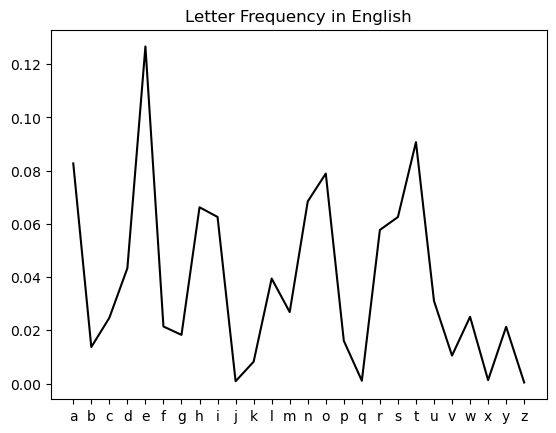

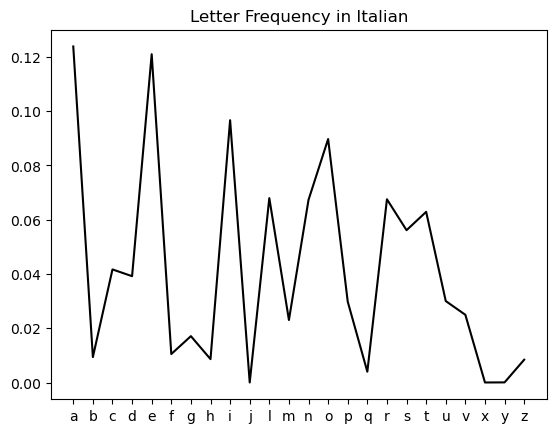

In [4]:
eng = LetterModel(name="English")
eng.load_text_from_file(ENGLISH_CORPUS)
eng.analyze()
eng.plot()
ital = LetterModel(name="Italian")
ital.load_text_from_file(ITALIAN_CORPUS)
ital.analyze()
ital.plot()

Here we see the _fingerprints_, so to speak, of how two different languages distribute their letters on average. As you can see, they work out as simple linear models. Now, our goal is ultimately to take a sample of text in an unknown language and determine its language by its distribution of letters. To accomplish this, let's implement the `LangTest` class.

In [5]:
class LangTest(object):
    def __init__(self, model):
        self.model = model
        self.languages = []
        
    def add(self, language, corpus):
        m = self.model(name=language)
        m.load_text_from_file(corpus)
        m.analyze()
        self.languages.append(m)
        
    def test(self, sample,exclude=[]):
        deltas = {}
        lowest = 1
        best_match = None
        for l in self.languages:
            if l in exclude:
                pass
            else:
                deltas[l.name] = l.compare(sample)
                if deltas[l.name] < lowest:
                    best_match = l.name
                    lowest = deltas[l.name]
        return (best_match,deltas)
    
    def compare(self):
        comp = {}
        for l in self.languages:
            comp[l.name] = self.test(l,exclude=[l])
        return comp

The `LangTest` object will help us organize our `LetterModel` (or any other variety of the `LangModel` types of objects we choose) and to use them as functions to compare them to a sample (which will also be a `LetterModel` or similar type object). Another interesting feature of this class is that it allows us to make comparisons between which languages are similar (or not) in their letter distributions. Before we implement that, let's add a quick helper function to make adding corpora easier.

In [6]:
def load_corpora(tester, corpora):
    """
    Helper function to load many corpora at once into a LangTest object. 
    Input:
        tester -- a LangTest object to load corpora onto
        corpora -- a hash of language names linked to filenames of corpora to analyze
    Output:
        a LangTest object with all corpora loaded
    """
    for k in corpora:
        tester.add(k,corpora[k])
    return tester

In [7]:
tester = LangTest(LetterModel)
tester = load_corpora(tester,default_corpora)
data = tester.compare()
for k in data:
    print(f"{k}'s closest language in distribution is {data[k][0]}")

Latin's closest language in distribution is French
English's closest language in distribution is French
German's closest language in distribution is Dutch
Dutch's closest language in distribution is German
Italian's closest language in distribution is Spanish
Spanish's closest language in distribution is Portuguese
French's closest language in distribution is Latin
Portuguese's closest language in distribution is Spanish


Interestingly, the relationships here are not necessarily reciprocal. Latin's closest language is French, and French's is Latin, unsurprisingly, but English's closest language is _also_ French. Even a thousand years after the conquest, English's affection for French is not exactly requited! Let's try now to use our models to detect the language of some sample...

In [11]:
sample_string="Il y a aujourd’hui trois cent quarante-huit ans six mois et dix-neuf jours que les Parisiens s’éveillèrent au bruit de toutes les cloches sonnant à grande volée dans la triple enceinte de la Cité, de l’Université et de la Ville."
samp = LetterModel(text=sample_string)
# Opening line to Notre-Dame de Paris by Victor Hugo
samp.analyze()
tester.test(samp)

('French',
 {'Latin': 0.00896220224339722,
  'English': 0.010167664066418515,
  'German': 0.009686559141935083,
  'Dutch': 0.013921920537425381,
  'Italian': 0.009976913102523957,
  'Spanish': 0.011854420180583204,
  'French': 0.0037239881014857657,
  'Portuguese': 0.018603878745604242})

French comes out on top, followed not surprisingly by Latin, for which, as we saw, French has a great affinity, and then not long after that by German. This result was achieved, again, by a simple linear model being compared with a sample of pretty modest size:

In [9]:
samp.get_token_len()

171

Which provokes the question: how large of a sample do we need to obtain reliable results? One way to answer this question is to whittle down our sample until we start getting wrong answers. Our function `testModel()` will do just that:

In [19]:
def testModel(model, corpora, sample_str,lang,verbose=False):
    """
    Input: 
        model -- an object in the LangModel family
        corpora -- a hash of language names linked to file names of corpora to analyze to create a language model
        sample_str -- a string of some language to be determined
        lang -- language name
    
    """
    tester = LangTest(model)
    tester = load_corpora(tester,corpora)
    for i in range(len(sample_str)-1):
        sample = model(text=sample_str[i:])
        sample.analyze()
        ans, deltas = tester.test(sample)
        if verbose:
            print(deltas)
            vals = sorted(deltas.values())
            diff = (vals[1] - vals[0])/vals[1]
            percent = round(diff * 100, ndigits=2)
            print(f"The answer is {ans}. The difference between the top two answers was {percent}%. Length of sample was {sample.get_token_len()}.")
        if ans != lang:
            vals = sorted(deltas.values())
            diff = (vals[1] - vals[0])/vals[1]
            percent = round(diff * 100, ndigits=2)
            if verbose:
                print(f"The answer is {ans}. The difference between the top two answers was {percent}%. Length of sample was {sample.get_token_len()}.")
            break
    return sample.get_token_len()

testModel(LetterModel,default_corpora,sample_string,'French')

87

It seems this particular example breaks down when there are only 87 characters left, at which point the model fails to distinguish it from Dutch. Interestingly, the first incorrect answer is Dutch, and not Latin, as we might expect--the sample has become so small that it is unrepresentative and the usual relationships between distributions have become unpredictable. Let's try doing this with a larger example and see if we can draw some reasonable conclusions about the sample size we need. (This test requires a bit of time to run.)

In [22]:
with open(TEST) as file:
    test_string = file.read()
    
substrings = []
for i in range(0,len(test_string),250):
    try:
        substrings.append(test_string[i:i+250])
    except IndexError:
        break

print(len(substrings))

minLengths=[]
for s in substrings:
    num = testModel(LetterModel,default_corpora,s,'English')
    minLengths.append(num)
print(f"Average was {sum(minLengths)/len(minLengths)} SD={plt.std(minLengths)}")

590
Average was 55.01864406779661 SD=44.98705642314326


So we see that we can get very reliable accuracy with a sample size of >100.

## Conclusion

Overall, then, we have seen --

* Languages are characterized by distinct distributions of letters
* These can be modeled from texts of comparatively modest size (thousands of characters on average), and thus
* Are easily trained
* They accurately identify languages from modest-sized samples (a hundred or more characters in some cases)
* Work very quickly, requiring only modest computational power (i.e. no GPUs or anything of that sort)

Further inquiry might be done on other possible implementations of `LangModel`. A model based only on distribution of the first and last letters of words might be very effective, one suspects, as it would discriminate between relatively inflected and relatively uninflected languages. Another approach could be an additive algorithm -- one that would trace letter distribution and also, for example, average word length. 